# Bay Wheels
https://www.lyft.com/bikes/bay-wheels/system-data
Initial exploration

**Current goal:** station occupancy histogram time distribution

### Notes
- all files have same field list except 2017 missing bike_share_for_all_trip field

In [1]:
%%bash
# btw, bootstrapped the data with:
# curl 'https://s3.amazonaws.com/baywheels-data' | grep -o '[^<>]*tripdata[^<>]*' | while read f; do wget "https://s3.amazonaws.com/baywheels-data/$f"; done; for f in *.zip; do unzip $f; done; rm *.zip
pwd
ls data

/Users/kuangxu/Git/bay-wheels
201906-baywheels-tripdata.csv


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time, datetime
%matplotlib inline

In [3]:
# load data
df = pd.read_csv("data/201906-baywheels-tripdata.csv", low_memory=False, parse_dates=['start_time', 'end_time'])
df

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method
0,81695,2019-06-30 18:16:09.773,2019-07-01 16:57:45.592,109.0,17th St at Valencia St,37.763316,-122.421904,56.0,Koshland Park,37.773414,-122.427317,1502,Subscriber,1957.0,Male,No,NaN
1,74260,2019-06-30 18:09:55.830,2019-07-01 14:47:36.681,50.0,2nd St at Townsend St,37.780526,-122.390288,101.0,15th St at Potrero Ave,37.767079,-122.407359,2526,Customer,NaN,NaN,No,NaN
2,59603,2019-06-30 15:40:31.038,2019-07-01 08:13:54.349,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,30.0,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,2427,Subscriber,1985.0,Male,No,NaN
3,67932,2019-06-30 12:49:47.781,2019-07-01 07:42:00.543,169.0,Bushrod Park,37.846516,-122.265304,248.0,Telegraph Ave at Ashby Ave,37.855956,-122.259795,1261,Customer,NaN,NaN,No,NaN
4,48894,2019-06-30 17:21:00.055,2019-07-01 06:55:54.996,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,30.0,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,1070,Customer,NaN,NaN,No,NaN
5,47409,2019-06-30 16:47:22.329,2019-07-01 05:57:32.072,340.0,Harmon St at Adeline St,37.849735,-122.270582,189.0,Genoa St at 55th St,37.839649,-122.271756,2966,Subscriber,1992.0,Male,No,NaN
6,37282,2019-06-30 14:31:39.573,2019-07-01 00:53:02.252,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,400.0,Buchanan St at North Point St,37.804272,-122.433537,1980,Customer,NaN,NaN,No,NaN
7,11105,2019-06-30 21:28:07.304,2019-07-01 00:33:12.624,377.0,Fell St at Stanyan St,37.771917,-122.453704,380.0,Masonic Ave at Turk St,37.779047,-122.447291,3515,Subscriber,1985.0,Other,No,NaN
8,27656,2019-06-30 16:50:35.490,2019-07-01 00:31:32.438,24.0,Spear St at Folsom St,37.789677,-122.390428,370.0,Jones St at Post St,37.787327,-122.413278,1836,Customer,NaN,NaN,No,NaN
9,1942,2019-06-30 23:48:21.581,2019-07-01 00:20:44.449,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,16.0,Steuart St at Market St,37.794130,-122.394430,1055,Customer,1996.0,Female,No,NaN


In [40]:
# list columns
df.columns

Index(['duration_sec', 'start_time', 'end_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       'member_birth_year', 'member_gender', 'bike_share_for_all_trip',
       'rental_access_method'],
      dtype='object')

In [41]:
# column data types
df.dtypes

duration_sec                        int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id                  float64
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                    float64
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bike_id                             int64
user_type                          object
member_birth_year                 float64
member_gender                      object
bike_share_for_all_trip            object
rental_access_method               object
dtype: object

array([109.,  50.,  23., 169.,  15., 340.,   6., 377.,  24.,   3., 167.,
       115.,  16., 411., 247.,  79.,  58.,  26.,  80.,  59., 307., 133.,
        21.,  44., 400.,  47., 243., 324., 276., 306.,  81.,  87.,  75.,
       341.,  95., 129.,  90., 136., 254.,  86.,   8., 182., 246., 139.,
       256., 215.,  61., 267.,  10., 200., 370.,  17.,  14., 291.,  88.,
        77., 121., 245.,  67., 212., 323.,  93., 127., 393., 404.,  35.,
       386., 150., 384., 118.,  72.,  55.,  63.,  27., 176., 279., 315.,
       336., 250., 107.,  37., 213., 125., 144., 289., 269.,  66.,  28.,
        34., 113., 137.,  60., 119., 120., 419., 230., 387.,  13.,  54.,
       338.,  62., 249., 252., 195.,  98., 282., 101., 371., 159., 194.,
       204., 241., 114., 278., 100., 368., 321., 141., 207., 146., 134.,
        64.,  74., 130., 239., 284., 356., 285., 160., 126., 193.,  96.,
        89., 108.,  52., 275., 178., 312.,  85.,  19.,   9., 399., 177.,
        92., 227.,  91., 223.,   7., 238., 186.,  2

In [32]:
# unique user types
df.user_type.unique()

array(['Subscriber', 'Customer'], dtype=object)

In [14]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

    
    


In [170]:

# unique station names
list_station_id=df.start_station_id.unique()
list_station_id


# Update arrival and departure processes

start_date = date(2019, 6, 1)
end_date = date(2019, 6, 2)

start_hour = 6
end_hour = 23

time_step_size = 15 #in minutes
n_time= int((end_hour-start_hour)*60/time_step)
time_list = np.zeros(n_time)
for n in range(n_time):
    time_list[n]=start_hour+n*time_step_size/60
    # time.strftime('%H:%M:%S', time.gmtime(start_hour*3600+n*time_step_size*60))
    #list of time intervals in hours

for this_date in daterange(start_date, end_date):
    filter_date = str(this_date)
    start_time = time.strftime('%H:%M:%S', time.gmtime(start_hour*3600))
    end_time = time.strftime('%H:%M:%S', time.gmtime(end_hour*3600))
    
    day_rides = df[((df.start_time > filter_date + " " + start_time) & (df.start_time <= filter_date + " " +end_time)) | ((df.end_time > filter_date + ' 00:00:00') & (df.end_time <= filter_date + ' 23:59:59'))]
    
    # Iterate through stations
    day_in = np.zeros(n_time)
    day_out = np.zeros(n_time)
    day_occup = np.zeros(n_time)
    occup_init = 0
    
    for this_station in list_station_id[0:2]:
        station_day_rides = day_rides[ (day_rides.start_station_id == this_station) | (day_rides.end_station_id == this_station) ]
        for index, ride in station_day_rides.iterrows():
            
            if ride.start_station_id  == this_station:                
                a = ride.start_time
                ride_time = a.hour*60+a.minute
                time_indx = int(ride_time/time_step_size)
                day_in[range(time_indx,n_time)] = day_in[range(time_indx,n_time)]+ 1
            
            if ride.end_station_id  == this_station:                
                a = ride.end_time
                ride_time = a.hour*60+a.minute
                time_indx = int(ride_time/time_step_size)
                day_out[range(time_indx,n_time)] = day_out[range(time_indx,n_time)]+ 1
                

            



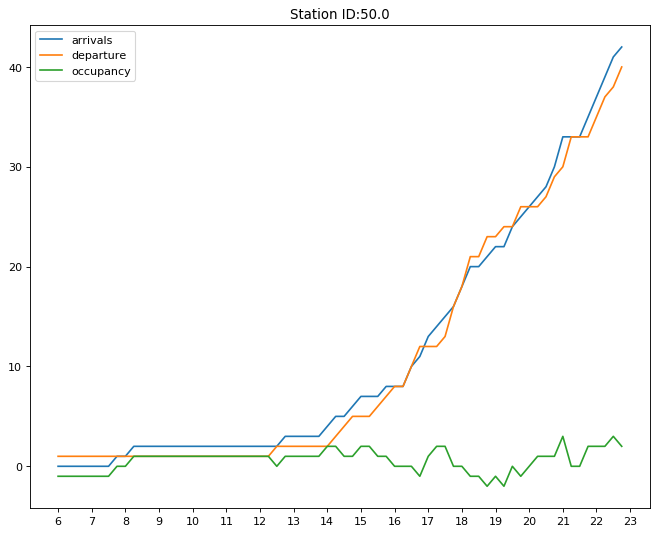

In [171]:
plt.figure(num=1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(time_list, day_in)
plt.plot(time_list, day_out)
plt.plot(time_list, day_in-day_out)
plt.xticks(np.arange(min(time_list), max(time_list)+1, 1.0))
plt.legend(["arrivals", "departure", "occupancy"])
plt.title("Station ID:" + str(this_station))
plt.show()


In [147]:
start_hour+n*time_step_size*60

6

NameError: name 'data' is not defined

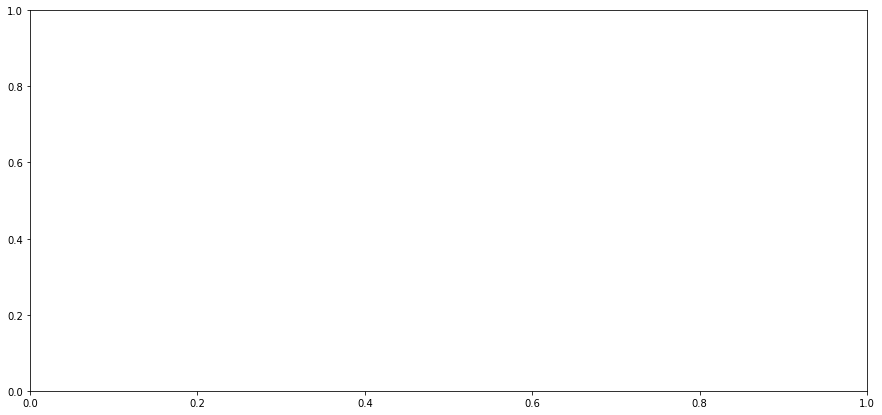

In [37]:
# if I had:

# I could graph:
fig, ax = plt.subplots(figsize=(15,7))
#data.plot(ax=ax)
ax.bar(data.index, data['count'])

#set ticks every week
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1))
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))